# PFI for AACR

In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import time
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score, brier_score_loss
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# Clustering
from sklearn.datasets import make_biclusters, make_checkerboard, make_classification
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralCoclustering, SpectralBiclustering
from sklearn.metrics import consensus_score

# Corr
from scipy.stats import spearmanr, pearsonr
from numpy import corrcoef

# Utils
file_path = os.getcwd()  # os.path.dirname(os.path.relpath(__file__))
utils_path = os.path.abspath(os.path.join(file_path, '..', '..', 'utils_py'))
sys.path.append(utils_path)
import utils_all as utils

# Feature importance
pfi_path = os.path.abspath(os.path.join(file_path, '..', 'pfi'))
sys.path.append(pfi_path)
import pfi
import pfi_utils

import rfpimp

import warnings
warnings.filterwarnings('ignore')

SEED=0

/Users/apartin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


## Data preproc

In [2]:
# Load data
# df_rna, meta = utils.load_lincs1000(dataset='combat', datadir='/vol/ml/apartin/Benchmarks/Data/Pilot1', sources=['gdc'])
df_rna, meta = utils.load_lincs1000(dataset='combat', datadir='/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1', sources=['gdc'])

df_rna (11081, 943)
meta   (11081, 20)


In [3]:
# Specify col name of the target variable (cancer type)
target_col_name = 'ctype'

In [4]:
# Drop small classes
min_class_size = 300
df_rna, df_rna_small = utils.drop_samples_on_class_count(df=df_rna, y=meta[target_col_name],
                                                         min_class_size=min_class_size)
df_rna, meta = utils.update_df_and_meta(df_rna, meta, on='Sample')
# print(f'df_rna.shape {df_rna.shape}')
# print(meta[target_col_name].value_counts())

In [5]:
# Balance classes
class_size = min_class_size
df_rna, y_out, dropped_classes = utils.balance_df(df=df_rna, y=meta[target_col_name],
                                                  class_size=class_size, seed=SEED)
df_rna, meta = utils.update_df_and_meta(df_rna, meta, on='Sample')
# print(f'df_rna.shape {df_rna.shape}')
# print(meta[target_col_name].value_counts())

In [6]:
xdata = df_rna.iloc[:, 1:].copy()
ydata = meta['ctype'].values
y_enc = LabelEncoder()
ydata = y_enc.fit_transform(ydata)
y_enc = pd.DataFrame(data={'label': np.arange(0, len(y_enc.classes_)),
                           'type': y_enc.classes_})

# Permute data
shuf_idx = np.random.permutation(df_rna.shape[0])
xdata = xdata.iloc[shuf_idx].reset_index(drop=True)
ydata = ydata[shuf_idx]

# Preprocess
xdata, idx = utils.drop_low_var_cols(xdata)

# Subset of features
xdata = xdata.sample(n=25, axis=1, random_state=SEED)

# Split data
xtr, xvl, ytr, yvl = train_test_split(xdata, ydata, test_size=0.2,
                                      random_state=SEED, stratify=ydata)

1 cols out of 942 were dropped based on col variance (th=1e-16).


In [7]:
print('xtr.shape', xtr.shape)
print('xvl.shape', xvl.shape)

xtr.shape (4080, 25)
xvl.shape (1020, 25)


In [8]:
# plt.scatter(range(xdata.shape[1]), xdata.var(axis=0));
# plt.xlabel('gene')
# plt.ylabel('var')

### Compute subgroups correlated features

0 cols out of 25 were dropped based on col variance (th=1e-16).


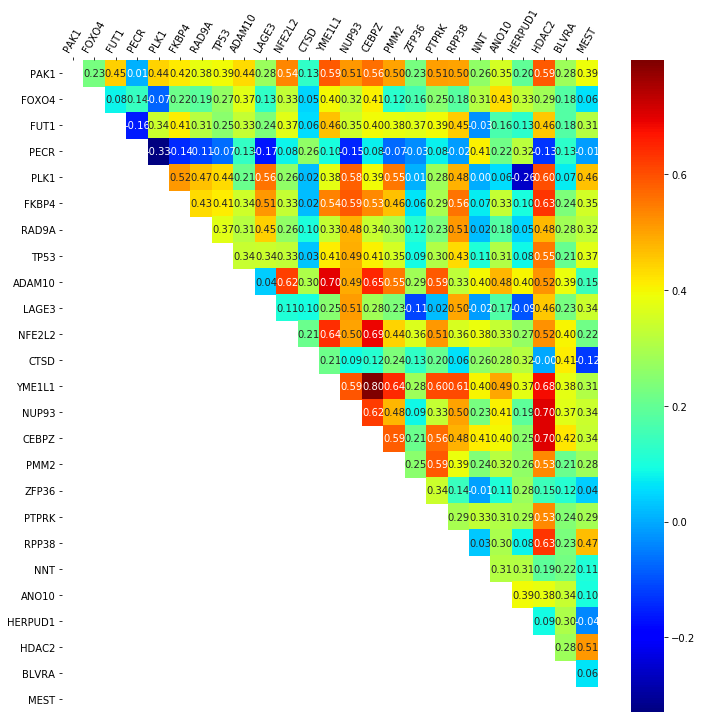

In [9]:
cor = utils.compute_cor_mat(xdata, zero_diag=True)
utils.plot_cor_heatmap(cor, full=False, figsize=(12,12));

In [10]:
# t0 = time.time()
# th = 0.80
# cor = utils.compute_cor_mat(xdata, zero_diag=True, decimals=5)
# cor = cor.applymap(lambda x: 1 if x > th else 0)
# print(cor.shape)

# idx = (cor.sum(axis=0) > 10**-3).values
# cor = cor.iloc[idx, idx]
# print(cor.shape)

# # Zeroing out the traignle may speedup the computation
# # mask = np.zeros_like(cor)
# # mask[np.triu_indices_from(mask)] = True
# # cor = cor * mask
# # utils.plot_cor_heatmap(cor, figsize=(8, 6), full=True)

# G = nx.from_pandas_adjacency(cor)
# print(nx.info(G)) 

# t0 = time.time()
# sub = [s for s in nx.enumerate_all_cliques(G) if len(s) > 1]
# print(f'Time to compute the cliques is {(time.time()-t0)/60:.2f} minutes')

# # utils.plot_cor_heatmap(cor, figsize=(20, 14), full=True)

In [11]:
# Test how much time it takes to compute the subgroups

# th_vec = np.arange(0.9, 0.4, -0.1)
# sub = []
# for t in th_vec:
#     print('threshold', t)
#     s = pfi_utils.get_fea_groups(xdata, th=t, toplot=False)
#     sub.append(s)

In [12]:
# col_sets = pfi_utils.get_fea_groups(xdata, th=0.70, toplot=True, figsize=(4,4))
# col_sets

In [13]:
# df = pd.DataFrame([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
# # df = pd.DataFrame([[0, 1, 0], [0, 0, 0], [0, 0, 0]])
# df = pd.DataFrame([[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 1, 1, 0]])
# print(df)
# G = nx.from_pandas_adjacency(df)
# print(nx.info(G))

# sub = [s for s in nx.enumerate_all_cliques(G) if len(s) > 1]
# # sub = list(nx.enumerate_all_cliques(G))
# print(sub)

# nx.draw(G)

## FI using MDI

In [14]:
rf_model = RandomForestClassifier(n_estimators=250, random_state=SEED, oob_score=True)
rf_model.fit(xtr, ytr);
score = rf_model.score(xvl, yvl)
print(score)

0.807843137254902


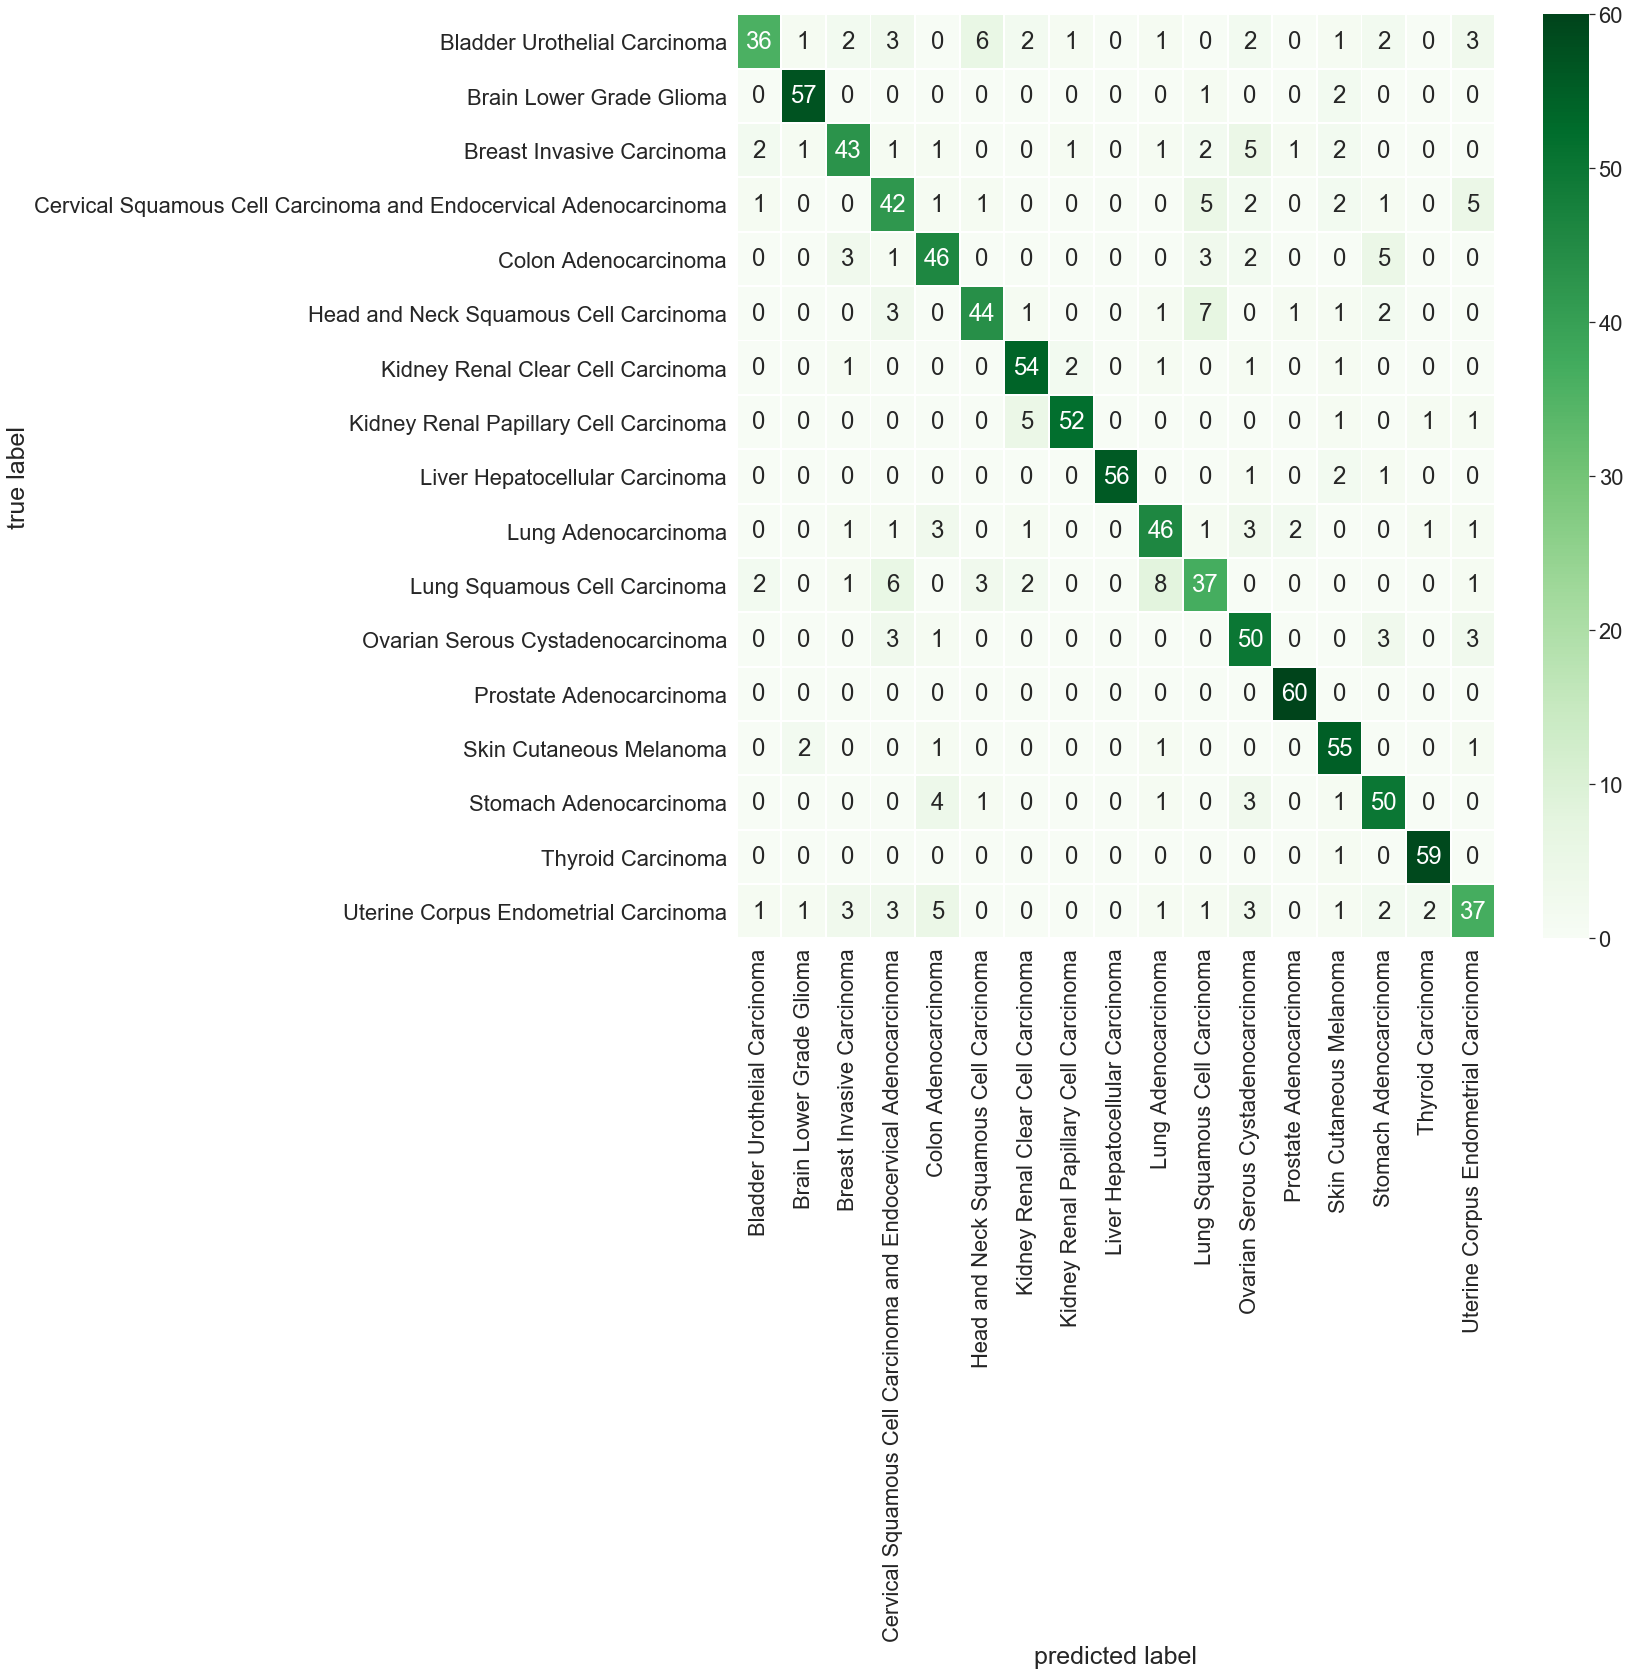

In [15]:
y_pred = rf_model.predict(xvl)
utils.plot_confusion_matrix(y_true=yvl, y_pred=y_pred, labels=y_enc['type'].values);

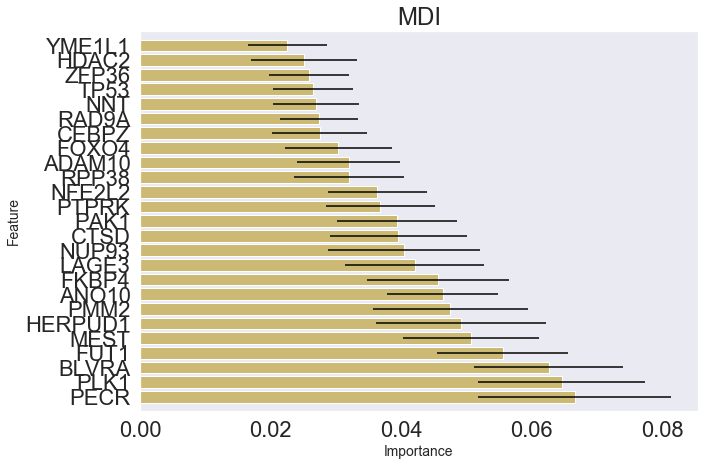

In [16]:
utils.plot_rf_fi(rf_model, columns=xdata.columns, title='MDI', figsize=(10,7));

## FI using MDA

In [17]:
fi = pfi.PFI(model=rf_model, xdata=xvl, ydata=yvl, n_shuffles=20, verbose=False)
fi.compute_pfi(ml_type='c');

col 1/25


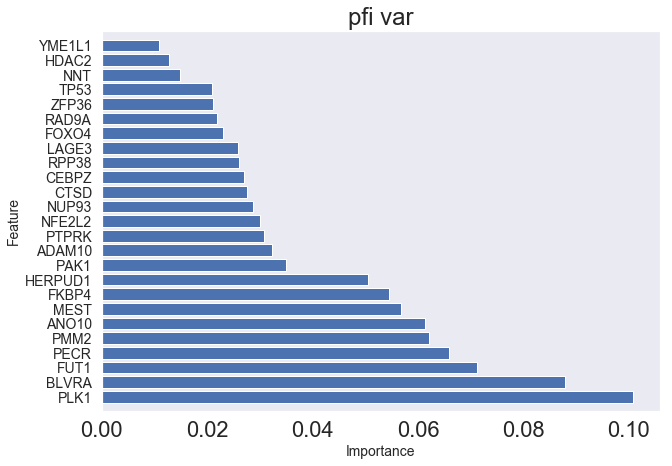

In [18]:
fi.plot_var_fi(title='pfi var', figsize=(10,7));

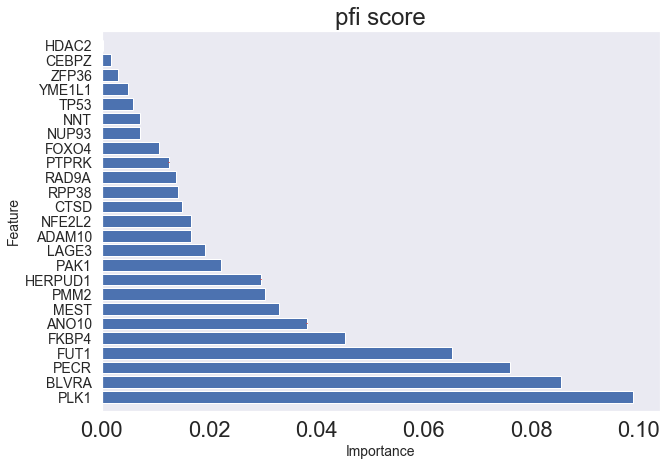

In [19]:
fi.plot_score_fi(title='pfi score', figsize=(10,7));

## FI using MDA (including col_sets)

0 cols out of 25 were dropped based on col variance (th=1e-16).
Corr matrix after removing features shape:  (3, 3)
Time to compute cliques:  0.00 min
col 1/24


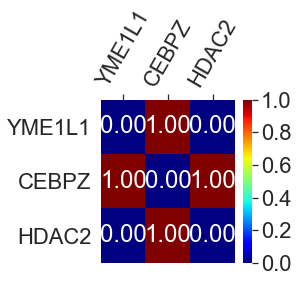

In [20]:
fi = pfi.PFI(model=rf_model, xdata=xvl, ydata=yvl, n_shuffles=20)
fi.gen_col_sets(th=0.7, toplot=True, figsize=(3,3))
fi.compute_pfi(ml_type='c')

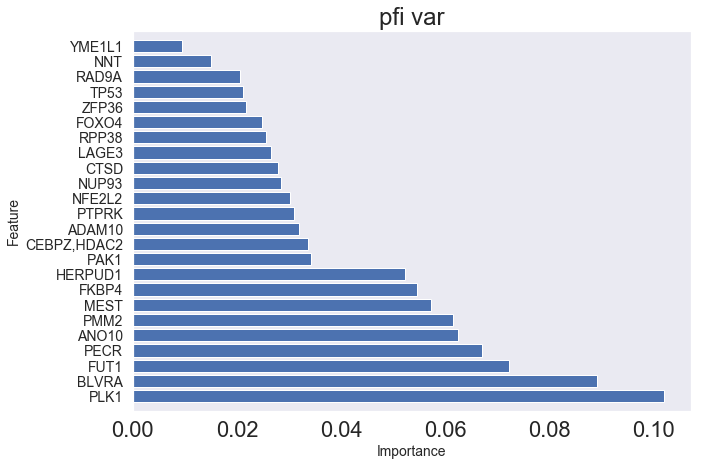

In [21]:
fi.plot_var_fi(title='pfi var', figsize=(10,7));

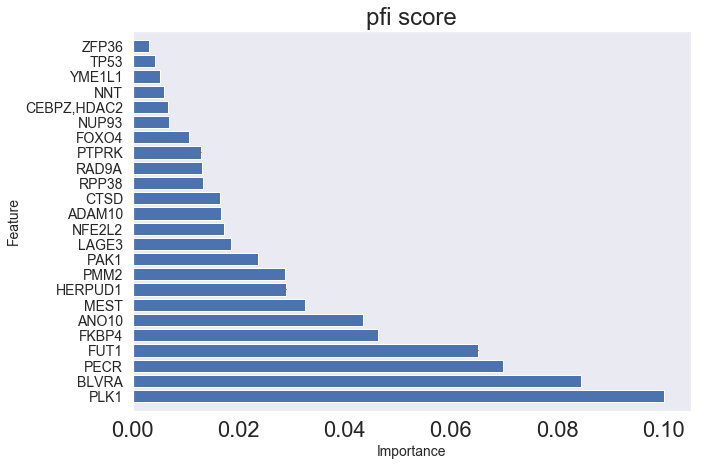

In [22]:
fi.plot_score_fi(title='pfi score', figsize=(10,7));

In [13]:
nt = pd.read_csv(os.path.join('/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1/nt_train2.csv'), sep=',')
nt.shape

(1119, 60484)

In [14]:
mm = pd.read_csv('/Users/apartin/droplet/feature-importance/apps/lincs1000.tsv', sep='\t')
mm.shape

(978, 5)

In [15]:
nt.head()

,0,456.733102303,0.0,44807.8723478,0.0.1,79595.1481823,166781.014694,0.0.2,325.147562802,2142157.49881,...,0.0.26713,1444.91630709,0.0.26714,2205.98981384.6,761.221837171.7,247138.885268,4660.7479649,0.0.26715,10877.0828381,243.636741273.1
0,1,0.000000,78.579416,28903.153906,0.0,124497.868573,269812.921183,0.0,2123.340838,2.896222e+06,...,0.0,0.000000,0.0,0.000000,943.875288,626010.838924,666.817367,0.0,10819.253113,0.0
1,1,0.000000,0.000000,93306.309062,0.0,195027.840224,238776.311467,0.0,3183.091418,3.130360e+06,...,0.0,2525.941418,0.0,5141.890467,0.000000,356687.310095,626.747843,0.0,43462.525691,0.0
2,1,11211.547894,111.116991,61812.206069,0.0,128086.941127,381735.944206,0.0,1292.240098,1.096682e+07,...,0.0,0.000000,0.0,0.000000,2669.416165,282435.827633,17915.633866,0.0,7125.658632,0.0
3,1,1861.593617,86.100675,19192.019880,0.0,63179.026516,250062.564291,0.0,161.976896,3.527659e+06,...,0.0,0.000000,0.0,1498.561755,0.000000,219016.974518,2313.699825,0.0,32641.359518,0.0
4,0,870.623214,120.801736,216357.719070,0.0,82814.325222,835147.625203,0.0,1611.467700,5.906938e+06,...,0.0,1180.412123,0.0,22426.938117,0.000000,843502.037732,4100.447641,0.0,66986.321291,0.0


In [19]:
mm

,gdc,ensembl,symbol,entrez,name
0,ENSG00000000003.13,ENSG00000000003,TSPAN6,7105,tetraspanin 6
1,ENSG00000000457.12,ENSG00000000457,SCYL3,57147,SCY1 like pseudokinase 3
2,ENSG00000002330.12,ENSG00000002330,BAD,572,BCL2 associated agonist of cell death
3,ENSG00000002549.11,ENSG00000002549,LAP3,51056,leucine aminopeptidase 3
4,ENSG00000002919.13,ENSG00000002919,SNX11,29916,sorting nexin 11
5,ENSG00000003400.13,ENSG00000003400,CASP10,843,caspase 10
6,ENSG00000003402.18,ENSG00000003402,CFLAR,8837,CASP8 and FADD like apoptosis regulator
7,ENSG00000004478.7,ENSG00000004478,FKBP4,2288,FK506 binding protein 4
8,ENSG00000004534.13,ENSG00000004534,RBM6,10180,RNA binding motif protein 6
9,ENSG00000004864.12,ENSG00000004864,SLC25A13,10165,solute carrier family 25 member 13
